In [1]:
# --- Step 0: Imports & seed ---
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

np.random.seed(23)

# --- Step 1: Create synthetic 3D data for two classes ---
mu_vec1 = np.array([0, 0, 0])
cov_mat  = np.eye(3)
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat, 20)

df0 = pd.DataFrame(class1_sample, columns=['feature1','feature2','feature3'])
df0['target'] = 1

mu_vec2 = np.array([1, 1, 1])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat, 20)

df1 = pd.DataFrame(class2_sample, columns=['feature1','feature2','feature3'])
df1['target'] = 0

# append() is removed in pandas 2.0 -> use concat
df = pd.concat([df0, df1], ignore_index=True)

# shuffle (keep reproducible order) and reset index
df = df.sample(len(df), random_state=23).reset_index(drop=True)

In [2]:
# --- Step 2: 3D scatter with Plotly ---
fig = px.scatter_3d(
    df,
    x='feature1', y='feature2', z='feature3',
    color=df['target'].astype(str),
)
fig.update_traces(
    marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')),
    selector=dict(mode='markers')
)
fig.show()

In [3]:
# --- Step 3: Standardize, Covariance, Eigen Decomposition (PCA math) ---
scaler = StandardScaler()
X_std = scaler.fit_transform(df[['feature1','feature2','feature3']])

# covariance across columns -> rowvar=False
covariance_matrix = np.cov(X_std, rowvar=False)
print('Covariance Matrix:\n', covariance_matrix)

# use eigh for symmetric matrices; sort eigenvalues descending
eigvals, eigvecs = np.linalg.eigh(covariance_matrix)
order = np.argsort(eigvals)[::-1]
eigen_values  = eigvals[order]
eigen_vectors = eigvecs[:, order]

print("\nEigenvalues (desc):\n", eigen_values)
print("\nEigenvectors (columns are PCs):\n", eigen_vectors)

Covariance Matrix:
 [[1.02564103 0.20478114 0.080118  ]
 [0.20478114 1.02564103 0.19838882]
 [0.080118   0.19838882 1.02564103]]

Eigenvalues (desc):
 [1.3536065  0.94557084 0.77774573]

Eigenvectors (columns are PCs):
 [[-0.53875915 -0.69363291  0.47813384]
 [-0.65608325 -0.01057596 -0.75461442]
 [-0.52848211  0.72025103  0.44938304]]


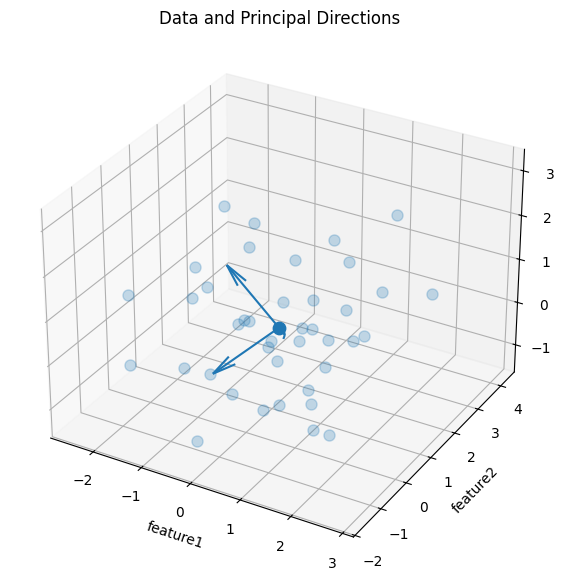

In [4]:
# --- Step 4: Matplotlib 3D plot with eigenvectors using quiver (simple & stable) ---
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(df['feature1'], df['feature2'], df['feature3'],
        'o', markersize=8, alpha=0.25)

# mean in ORIGINAL feature space (for visualization baseline)
mean_pt = df[['feature1','feature2','feature3']].mean().values

# Plot arrows for each principal component (projected in original space direction)
# Use standardized-space eigenvectors to show directions; draw from mean
for i in range(3):
    v = eigen_vectors[:, i]     # direction
    ax.quiver(mean_pt[0], mean_pt[1], mean_pt[2],
              v[0], v[1], v[2],
              length=1.5, normalize=True)

ax.scatter(*mean_pt, s=80)
ax.set_xlabel('feature1')
ax.set_ylabel('feature2')
ax.set_zlabel('feature3')
ax.set_title('Data and Principal Directions')
plt.show()

In [5]:
# --- Step 5: Project onto first two principal components ---
# PC matrix: first two eigenvectors (columns)
pc = eigen_vectors[:, :2]         # shape (3,2)

# Project STANDARDIZED data onto PCs
transformed = X_std @ pc          # (40,2)

new_df = pd.DataFrame(transformed, columns=['PC1','PC2'])
new_df['target'] = df['target'].astype(str)

fig = px.scatter(
    new_df, x='PC1', y='PC2', color='target',
    color_discrete_sequence=px.colors.qualitative.G10
)
fig.update_traces(
    marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')),
    selector=dict(mode='markers')
)
fig.show()